In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import warnings
import string
import re
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, roc_curve, classification_report, confusion_matrix, precision_recall_curve, auc

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
data = pd.read_csv('data/news_political_dataset.csv')
data.sample(5)

,headline,short_description,is_political
56014,Iggy Azalea And Weird Al?!,NaN,0
8103,Why We Should All Take A Knee For Black And Br...,"Fall has arrived. The air is crisp, pumpkins a...",1
34318,'Saturday Night Live' Jokes About What Happene...,"It was ""the day that shook the whole white wor...",0
6622,Donald Trump Says He Rejected 'Probably' Being...,"Time later tweeted that the president was ""inc...",1
51912,Where's The Cast Of 'The Room' Now?,NaN,0


In [3]:
def clf_model(model_type, X_train, y_train, X_valid):
    model = model_type.fit(X_train,y_train)
    predicted_labels = model.predict(X_valid)
    predicted_probab = model.predict_proba(X_valid)[:,1]
    return [predicted_labels,predicted_probab, model]

In [4]:
def model_evaluation(actual_values, predicted_values, predicted_probabilities):
    cfn_mat = confusion_matrix(actual_values,predicted_values)
    print("confusion matrix: \n",cfn_mat)
    print("\naccuracy: ",accuracy_score(actual_values,predicted_values))
    print("\nclassification report: \n", classification_report(actual_values,predicted_values))
    fpr,tpr,threshold=roc_curve(actual_values, predicted_probabilities)
    print ('\nArea under ROC curve for validation set:', auc(fpr,tpr))
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(fpr,tpr,label='Validation set AUC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    ax.legend(loc='best')
    plt.show()

In [5]:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
stop_words = stop_words + list(string.printable)
data['cleaned_headline_text'] = data['short_description'].apply(\
lambda x : ' '.join([lemmatizer.lemmatize(word.lower()) \
    for word in word_tokenize(re.sub(r'([^\s\w]|_)+', ' ', str(x))) if word.lower() not in stop_words]))

In [6]:
MAX_FEATURES = 200
tfidf_model = TfidfVectorizer(max_features=MAX_FEATURES)
tfidf_df = pd.DataFrame(tfidf_model.fit_transform(data['cleaned_headline_text']).todense())
tfidf_df.columns = sorted(tfidf_model.vocabulary_)
tfidf_df.head()

,10,administration,already,also,always,america,american,another,around,away,...,white,win,without,woman,work,world,would,year,yet,york
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(tfidf_df, data['is_political'], test_size=0.2, random_state=42,stratify = data['is_political'])

In [8]:
pip install xgboost

     |████████████████████████████████| 127.6 MB 14 kB/s s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


confusion matrix: 
 [[6862  491]
 [3498 3050]]

accuracy:  0.7130422271779009

classification report: 
               precision    recall  f1-score   support

           0       0.66      0.93      0.77      7353
           1       0.86      0.47      0.60      6548

    accuracy                           0.71     13901
   macro avg       0.76      0.70      0.69     13901
weighted avg       0.76      0.71      0.69     13901


Area under ROC curve for validation set: 0.7499565605185604


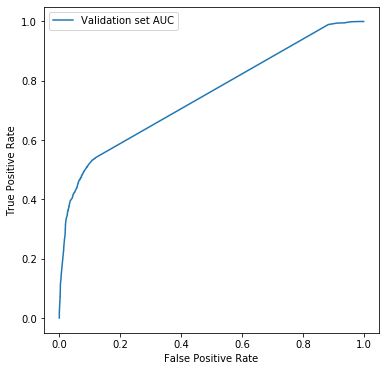

In [9]:
from xgboost import XGBClassifier
xgb_clf=XGBClassifier(n_estimators=10,learning_rate=0.05,max_depth=18,subsample=0.6,colsample_bytree= 0.6,reg_alpha= 10,seed=42)
results = clf_model(xgb_clf, X_train, y_train, X_valid)
model_evaluation(y_valid, results[0], results[1])
model_xgb = results[2]

In [10]:
word_importances = pd.DataFrame({'word':X_train.columns,'importance':model_xgb.feature_importances_})
word_importances.sort_values('importance', ascending = False).head(4)

,word,importance
178,trump,0.192977
136,president,0.093427
144,republican,0.070339
25,clinton,0.043241
